# Multimodal Emotion Recognition from Speech and Text

Emotion plays a central role in human communication. Our emotions reflect both  in *what we say* and *how we say it*. Being able to detect these emotions computationally opens up a wide range of powerful applications.
Being able to detect emotions can have a wide range of applications such as : AI Assisstants like Alexa can be better able to learn users behaviour and respond according to the mood, or it could be helpful in mental health treatment where audio and textual behaviour can be used to predict human's response.

### Why text alone is not enough
“I’m sorry, but you’re being extremely unhelpful.”

- Polite phrasing — but emotionally, it’s **criticism** or **frustration**.
- **Tone and pacing** matter, but are missing from text.

### Why Speech alone is not enough
 “I’m fine.”

- Could sound sad, angry, or genuinely okay — depends on **intonation**.
- Models relying only on pitch and energy **miss semantic meaning**.

In this project, we aim to classify emotions that takes a **spoken utterance and its transcript** as input, and predicts the associated emotion from seven categories: *anger, disgust, fear, joy, sadness, surprise, and neutral*.

We start off with unimodal approaches, then go for early fusion

In [31]:
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import re

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## About the Dataset

Multimodal EmotionLines Dataset (MELD) has been created by enhancing and extending EmotionLines dataset. MELD contains the same dialogue instances available in EmotionLines, but it also encompasses audio and visual modality along with text. MELD has more than 1400 dialogues and 13000 utterances from Friends TV series. Multiple speakers participated in the dialogues. Each utterance in a dialogue has been labeled by any of these seven emotions -- Anger, Disgust, Sadness, Joy, Neutral, Surprise and Fear. MELD also has sentiment (positive, negative and neutral) annotation for each utterance.

The available emotion labels include: **anger**, **disgust**, **fear**, **joy**, **neutral**, **sadness**, and **surprise**.
The audio clips are stored in `.mp4` format and named using a consistent pattern like `dia0_utt2.mp4`, which links them to the corresponding entry in the CSV.


In [4]:
DATA_PATH = '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train'

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_sent_emo.csv'))

print(train_df.head())

   Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my companys tr...         Chandler   
1       2                   You mustve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So lets talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

      StartTime       EndTime  
0  00:16:16,059  00:16:21,731  
1  00:16:21,940  00:16:23,442  
2 

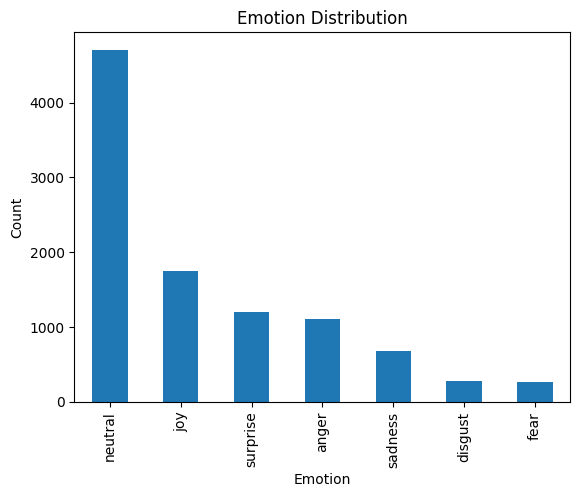

In [5]:
train_df['Emotion'].value_counts().plot(kind='bar', title='Emotion Distribution')
plt.ylabel("Count")
plt.show()

# Emotion Imbalance
When we looked at the distribution of emotion labels in the MELD dataset, we found that it was very skewed. The 'neutral' emotion had far more samples than the others — sometimes three to four times more. This causes a problem because models tend to overfit to the majority class and ignore the others.

# Sampling Strategy
We didn’t want to completely remove this imbalance as neutral is a common emotion. But we also didn’t want the model to predict neutral for everything. So, we used a custom sampling strategy. We kept the proportions of the minority classes roughly in line with their original distribution, but we reduced the number of neutral samples. This way, the model still learns what neutral looks like, but doesn’t get biased towards it.
The final sampled set had around 1000 entries, and we tried to keep it as representative as possible while preventing neutral from dominating. This helped improve model fairness and gave better results across all classes.

In [7]:
def downweight_neutral_proportional_sample(df, target_size=550, neutral_weight=0.5, random_state=42):
    emotion_counts = df['Emotion'].value_counts()
    total = emotion_counts.sum()

    proportions = emotion_counts / total

    adjusted_weights = proportions.copy()
    adjusted_weights['neutral'] *= neutral_weight

    adjusted_weights /= adjusted_weights.sum()

    samples_per_class = (adjusted_weights * target_size).astype(int)

    sampled_dfs = []
    for emotion, n in samples_per_class.items():
        available = df[df['Emotion'] == emotion]
        sampled = available.sample(n=min(len(available), n), random_state=random_state)
        sampled_dfs.append(sampled)

    final_df = pd.concat(sampled_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return final_df

# Sample Audio Data

Text: also I was the point person on my companys transition from the KL-5 to GR-6 system.
Emotion: neutral
Audio loaded: dia0_utt0.mp4 | Duration: 5.67s | Sample rate: 48000


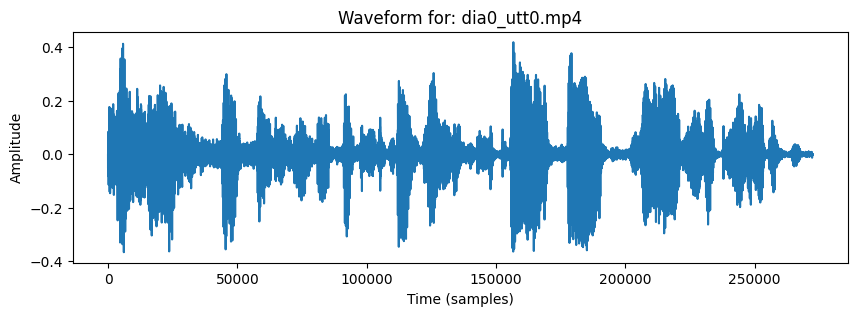

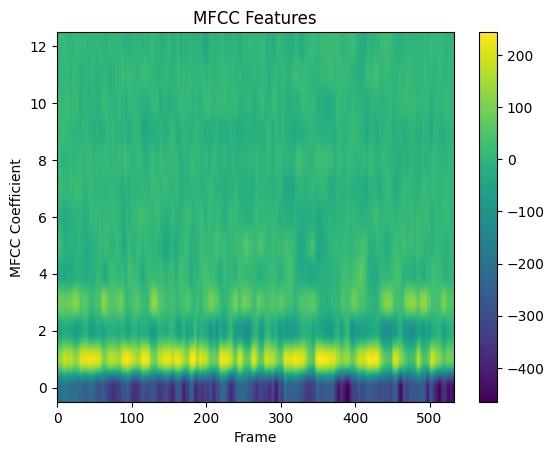

MFCC shape: (13, 533)


In [6]:
sample_row = train_df.iloc[0]
dialog_id = sample_row['Dialogue_ID']
utterance_id = sample_row['Utterance_ID']
emotion = sample_row['Emotion']
text = sample_row['Utterance']

print(f"Text: {text}")
print(f"Emotion: {emotion}")

audio_filename = f'dia{dialog_id}_utt{utterance_id}.mp4'
audio_path = os.path.join(DATA_PATH, 'train_splits', audio_filename)

y, sr = librosa.load(audio_path, sr=None)
print(f"Audio loaded: {audio_filename} | Duration: {len(y)/sr:.2f}s | Sample rate: {sr}")

plt.figure(figsize=(10, 3))
plt.plot(y)
plt.title(f"Waveform for: {audio_filename}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.imshow(mfccs, aspect='auto', origin='lower')
plt.title("MFCC Features")
plt.xlabel("Frame")
plt.ylabel("MFCC Coefficient")
plt.colorbar()
plt.show()

print("MFCC shape:", mfccs.shape)

# Sub-Sampling from the data

 97%|█████████▋| 962/996 [02:56<00:06,  5.10it/s]

Failed: dia125_utt3.mp4


100%|██████████| 996/996 [03:02<00:00,  5.46it/s]


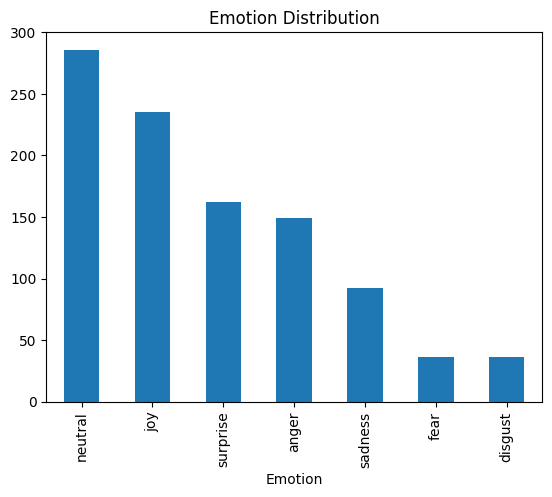

In [8]:
subset_df = downweight_neutral_proportional_sample(train_df, target_size=1000, neutral_weight=0.45)
subset_df['Emotion'].value_counts().plot(kind='bar', title='Emotion Distribution')
cached_audio = []

for i, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    dialog_id = row['Dialogue_ID']
    utterance_id = row['Utterance_ID']
    audio_filename = f'dia{dialog_id}_utt{utterance_id}.mp4'
    audio_path = os.path.join(DATA_PATH, 'train_splits', audio_filename)

    try:
        y, sr = librosa.load(audio_path, sr=None)
        cached_audio.append((y, sr))
    except Exception as e:
        print(f"Failed: {audio_filename}")
        cached_audio.append((None, None))

# Audio only model

## Audio Feature Extraction

Our first approach focused on using only the audio modality. For this, we extracted several hand-crafted features that are commonly used in speech analysis. These features capture the energy, frequency, and tonal characteristics of speech, which often reflect emotional states.

## MFCC (Mel-Frequency Cepstral Coefficients):
MFCCs are one of the most popular features in audio processing. They represent the short-term power spectrum of a sound, based on a scale that mimics the human ear's perception of frequency. We extracted the first 13 MFCCs from each audio file. These coefficients give us a compact representation of the tone and timbre of the speech.

In [9]:
mfcc_features = []

for y, sr in cached_audio:
    if y is None:
        mfcc_features.append(np.zeros(13))
        continue

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_features.append(mfcc_mean)


## Zero Crossing Rate (ZCR):
This measures how often the signal crosses the zero axis. It is a rough indicator of the noisiness or abruptness in the audio. Higher ZCR may be associated with more energetic or aggressive speech.

In [10]:
zcr_features = []

for y, sr in cached_audio:
    if y is None:
        zcr_features.append(0.0)
        continue

    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_features.append(zcr.mean())


## Spectral Centroid:
This is the "center of mass" of the spectrum. It tells us where the energy of the audio is concentrated in the frequency spectrum. Emotions like surprise or anger tend to shift energy toward higher frequencies, which is reflected in the centroid.

In [11]:
centroid_features = []

for y, sr in cached_audio:
    if y is None:
        centroid_features.append(0.0)
        continue

    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_features.append(centroid.mean())


## Root Mean Square (RMS) Energy:
This gives us an idea of the overall loudness of the signal. Louder speech is often linked with more intense emotions like anger or joy.

In [12]:
rms_features = []

for y, sr in cached_audio:
    if y is None:
        rms_features.append(0.0)
        continue

    rms = librosa.feature.rms(y=y)
    rms_features.append(rms.mean())


# Creating the feature matrix
These 16 (13 averaged MFCC coefficients, 1 average Zero Crossing Rate, 1 average Spectral Centroid, 1 average RMS Energy) values formed the complete audio feature vector for a single sample. We did this for every utterance in our balanced subset. This transformation gave us a clean, uniform dataset that was easier to handle in classical classification models like logistic regression, k-nearest neighbors, and random forest.

In [13]:
feature_matrix = np.hstack([
    np.array(mfcc_features),
    np.array(zcr_features).reshape(-1, 1),
    np.array(centroid_features).reshape(-1, 1),
    np.array(rms_features).reshape(-1, 1)
])

columns = [f"MFCC_{i+1}" for i in range(13)] + ["ZCR", "Centroid", "RMS"]
features_df = pd.DataFrame(feature_matrix, columns=columns)
features_df['Emotion'] = subset_df['Emotion'].values

features_df.head()


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,ZCR,Centroid,RMS,Emotion
0,-359.653961,148.291656,-67.549385,19.453568,-38.083397,10.207600,-18.181976,-10.154013,-7.201939,-13.625557,-2.096885,-5.449670,6.494117,0.095716,3206.485113,0.022048,sadness
1,-400.527618,178.266846,-75.182030,34.147179,-2.783864,7.227491,1.831435,-14.871428,-2.356879,-17.841095,2.683259,-6.306833,-16.415123,0.069999,2348.966012,0.020000,fear
2,-398.751221,179.429138,-61.588860,28.089268,-33.055580,11.889346,-14.022672,7.194049,-4.404149,-8.204381,-1.816592,0.044362,2.710975,0.041775,2287.592037,0.013260,neutral
3,-426.621094,115.213554,-55.236198,35.219738,-11.554382,-1.188914,-12.054434,-13.215525,0.774453,-15.610301,-9.530713,-15.458492,-8.458936,0.098395,3249.050866,0.017122,surprise
4,-449.376770,123.690346,-55.033478,42.768116,-1.662480,8.084108,-2.504400,-3.515490,2.957868,-3.772718,7.063086,0.913362,5.619586,0.090298,3299.660683,0.008834,joy


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [15]:
X = features_df.drop(columns=['Emotion'])
y = features_df['Emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
def evaluate_classifier(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    pca = PCA(n_components=2)
    X_vis = pca.fit_transform(X_test)
    vis_df = pd.DataFrame(X_vis, columns=["PC1", "PC2"])
    vis_df["Emotion"] = y_pred

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=vis_df, x="PC1", y="PC2", hue="Emotion", palette="tab10")
    plt.title(f"{name} - PCA Projection")
    plt.show()


## Logistic Regression

Logistic Regression is a widely-used linear classification algorithm. It estimates the probability of each class by fitting a logistic function over a linear combination of the input features.

It's easy to interpret and often performs well on datasets where the classes are linearly separable. However, it struggles when the relationship between features and classes is non-linear. In our experiments, we used it as a reliable baseline to compare with more complex models.


## K-Nearest Neighbors (KNN)

KNN is a simple, instance-based learning algorithm that classifies a data point by looking at the majority class among its nearest neighbors in the feature space.

It makes no assumptions about the underlying data distribution, which can be helpful in non-linear settings. However, it is sensitive to the scale of features and can be inefficient on large datasets. It also tends to struggle when classes overlap significantly, as we saw in our results.


## Random Forest

Random Forest is an ensemble learning method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting.

It can model complex, non-linear relationships and handles feature interactions well. It’s generally robust to noise and works well out-of-the-box. In our experiments, Random Forest consistently outperformed simpler models, especially when the feature space was more expressive.


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


KNN Classification Report:
              precision    recall  f1-score   support

       anger       0.23      0.33      0.27        30
     disgust       0.00      0.00      0.00         7
        fear       0.33      0.14      0.20         7
         joy       0.22      0.26      0.24        47
     neutral       0.37      0.39      0.38        57
     sadness       0.00      0.00      0.00        19
    surprise       0.26      0.15      0.19        33

    accuracy                           0.25       200
   macro avg       0.20      0.18      0.18       200
weighted avg       0.25      0.25      0.24       200



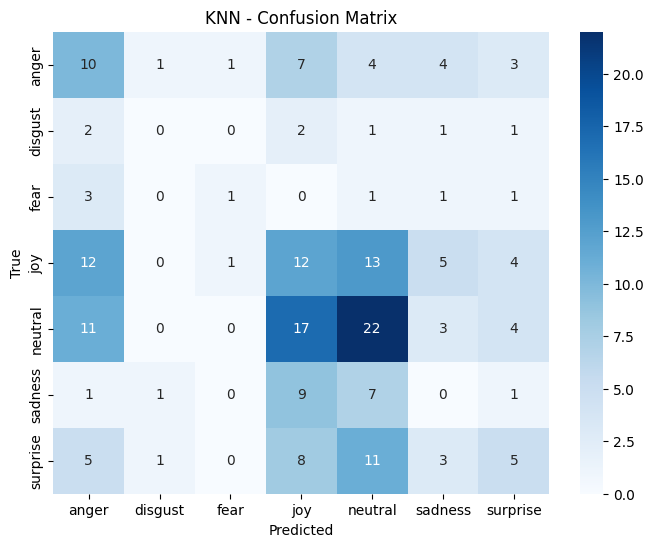

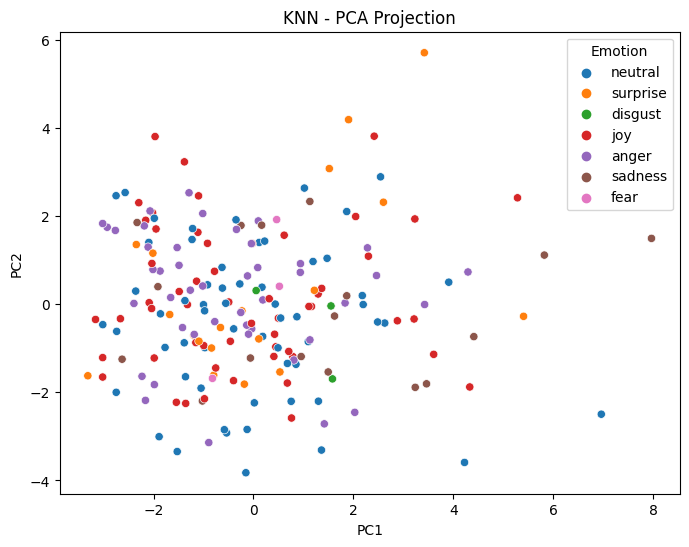

In [18]:
evaluate_classifier("KNN", KNeighborsClassifier(n_neighbors=5), X_train_scaled, X_test_scaled, y_train, y_test)



Random Forest Classification Report:
              precision    recall  f1-score   support

       anger       0.24      0.17      0.20        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.25      0.40      0.31        47
     neutral       0.34      0.54      0.42        57
     sadness       0.00      0.00      0.00        19
    surprise       0.08      0.03      0.04        33

    accuracy                           0.28       200
   macro avg       0.13      0.16      0.14       200
weighted avg       0.21      0.28      0.23       200



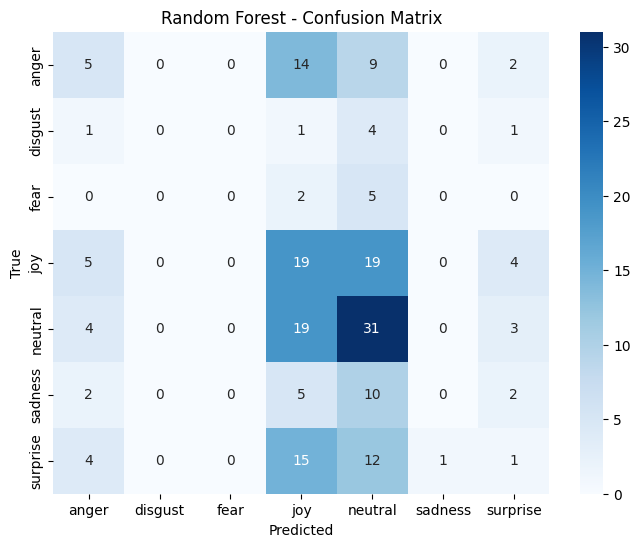

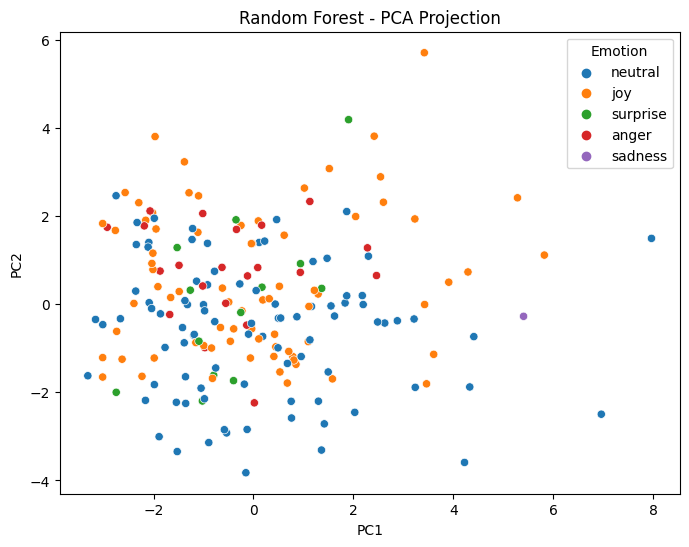

In [19]:
evaluate_classifier("Random Forest", RandomForestClassifier(n_estimators=100), X_train_scaled, X_test_scaled, y_train, y_test)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

       anger       0.25      0.13      0.17        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.21      0.26      0.23        47
     neutral       0.27      0.51      0.36        57
     sadness       0.00      0.00      0.00        19
    surprise       0.13      0.06      0.08        33

    accuracy                           0.23       200
   macro avg       0.12      0.14      0.12       200
weighted avg       0.19      0.23      0.20       200



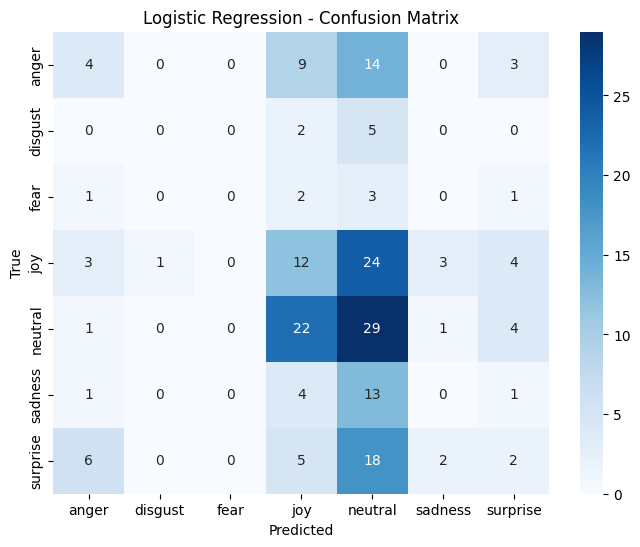

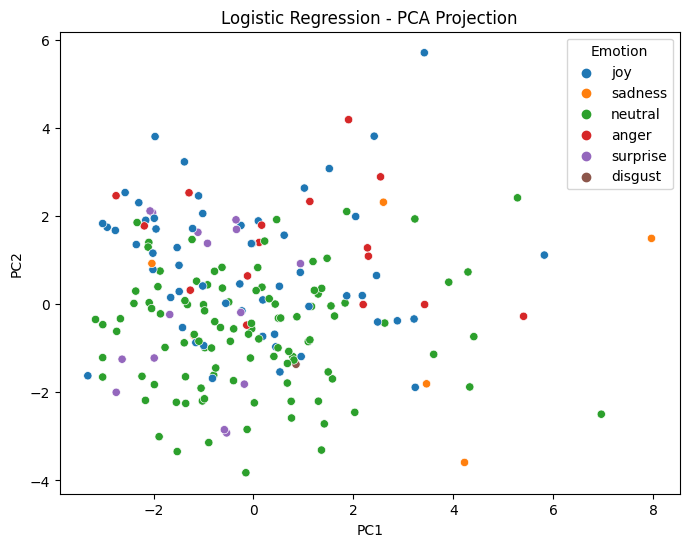

In [20]:
evaluate_classifier("Logistic Regression", LogisticRegression(max_iter=1000), X_train_scaled, X_test_scaled, y_train, y_test)


## TF-IDF Feature Extraction

We began our text-based emotion classification experiments using TF-IDF (Term Frequency–Inverse Document Frequency) as our feature representation.

TF-IDF transforms each utterance into a sparse vector based on how frequently each word appears in that utterance, and how rare that word is across the dataset. Common words like "the" or "is" are downweighted, while emotionally informative words like "hate", "excited", or "afraid" may be upweighted if they occur less frequently overall.

This method captures word presence and importance, but not word order or semantics. As a result, sentences like "I am happy" and "I am not happy" can look deceptively similar to a TF-IDF model.

Despite its limitations, TF-IDF is lightweight, fast, and often performs reasonably well as a baseline. We extracted the top 1000 unigrams and bigrams to represent each utterance in this vectorized form.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = subset_df['Utterance'].values
labels = subset_df['Emotion'].values

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(texts)

print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")


TF-IDF feature matrix shape: (996, 1000)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, stratify=labels, test_size=0.2, random_state=42
)


In [23]:
def evaluate_tfidf_classifier(name, model, X_train, X_test, y_train, y_test):
    """
    Evaluate a classifier trained on sparse TF-IDF vectors.
    Includes: classification report, confusion matrix, PCA projection.
    """
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.decomposition import PCA
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    X_test_dense = X_test.toarray()
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test_dense)

    vis_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    vis_df["Emotion"] = y_pred

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=vis_df, x="PC1", y="PC2", hue="Emotion", palette="tab10")
    plt.title(f"{name} - PCA Projection (TF-IDF)")
    plt.show()



Logistic Regression (TF-IDF) Classification Report:
              precision    recall  f1-score   support

       anger       0.15      0.07      0.09        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.30      0.36      0.33        47
     neutral       0.30      0.58      0.40        57
     sadness       0.00      0.00      0.00        19
    surprise       0.42      0.24      0.31        33

    accuracy                           0.30       200
   macro avg       0.17      0.18      0.16       200
weighted avg       0.25      0.30      0.25       200



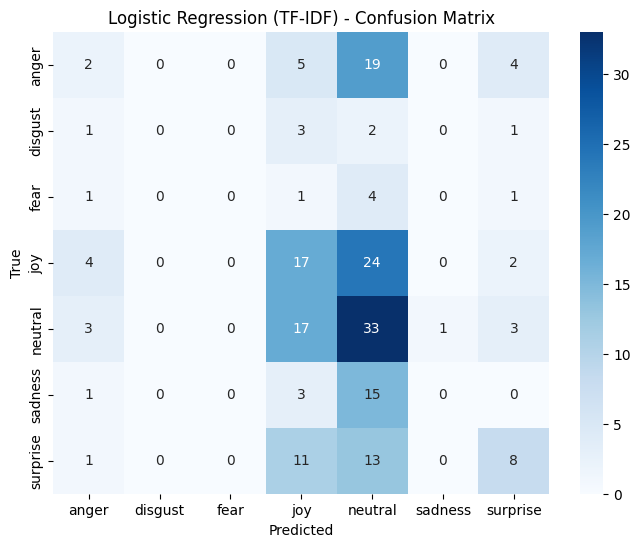

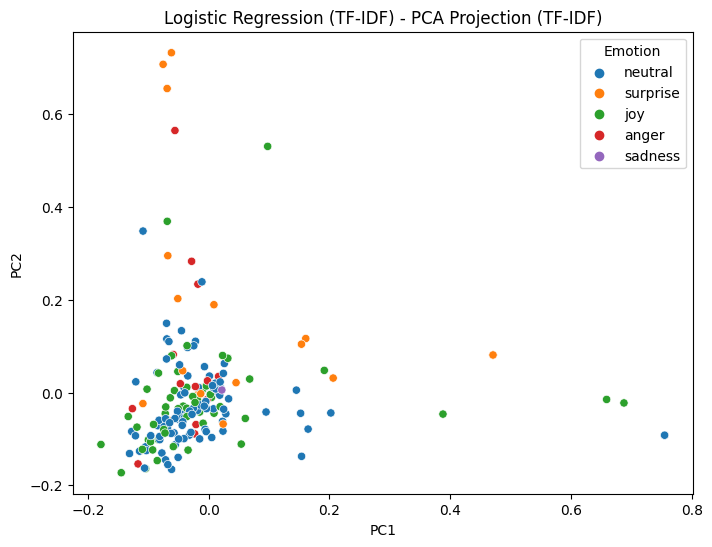

In [24]:
evaluate_tfidf_classifier("Logistic Regression (TF-IDF)", LogisticRegression(max_iter=1000),
                          X_train, X_test, y_train, y_test)


KNN (TF-IDF) Classification Report:
              precision    recall  f1-score   support

       anger       0.12      0.07      0.09        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.39      0.23      0.29        47
     neutral       0.29      0.72      0.41        57
     sadness       0.33      0.11      0.16        19
    surprise       0.40      0.06      0.11        33

    accuracy                           0.29       200
   macro avg       0.22      0.17      0.15       200
weighted avg       0.29      0.29      0.23       200



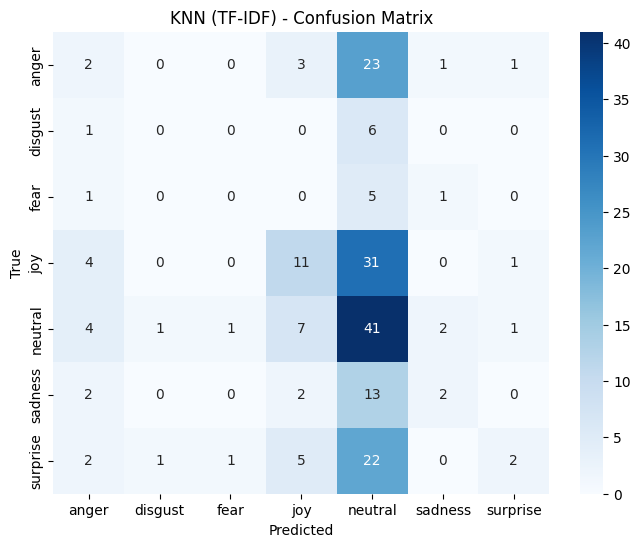

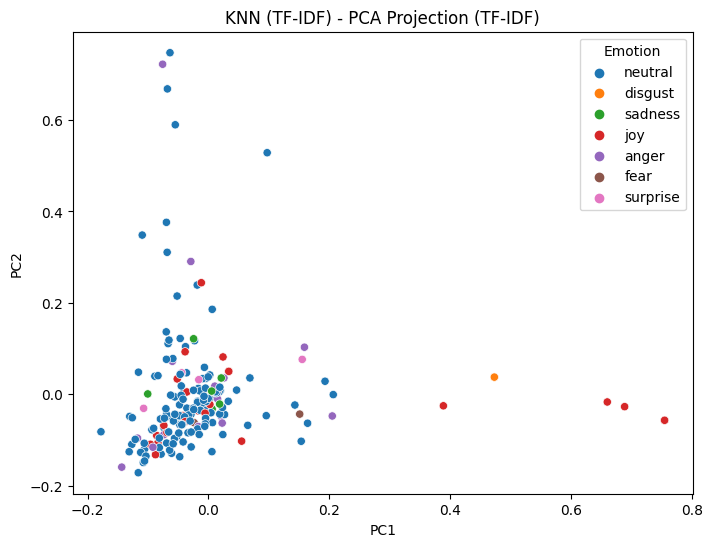

In [25]:
evaluate_tfidf_classifier("KNN (TF-IDF)", KNeighborsClassifier(n_neighbors=5),
                          X_train, X_test, y_train, y_test)



Random Forest (TF-IDF) Classification Report:
              precision    recall  f1-score   support

       anger       0.31      0.13      0.19        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.30      0.30      0.30        47
     neutral       0.30      0.56      0.40        57
     sadness       0.38      0.16      0.22        19
    surprise       0.44      0.33      0.38        33

    accuracy                           0.32       200
   macro avg       0.25      0.21      0.21       200
weighted avg       0.31      0.32      0.29       200



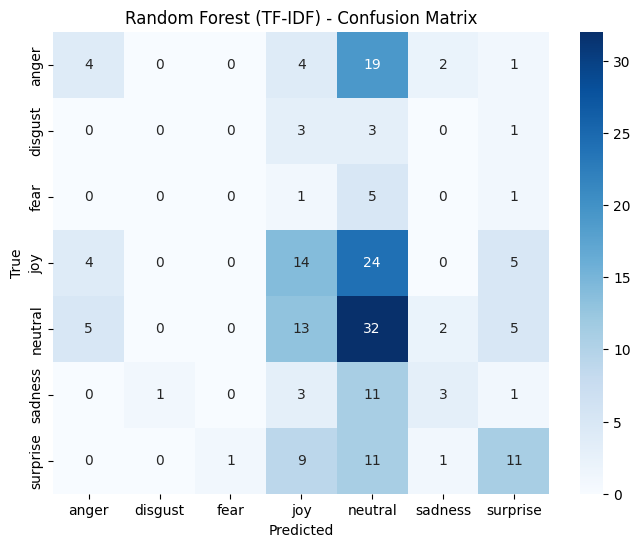

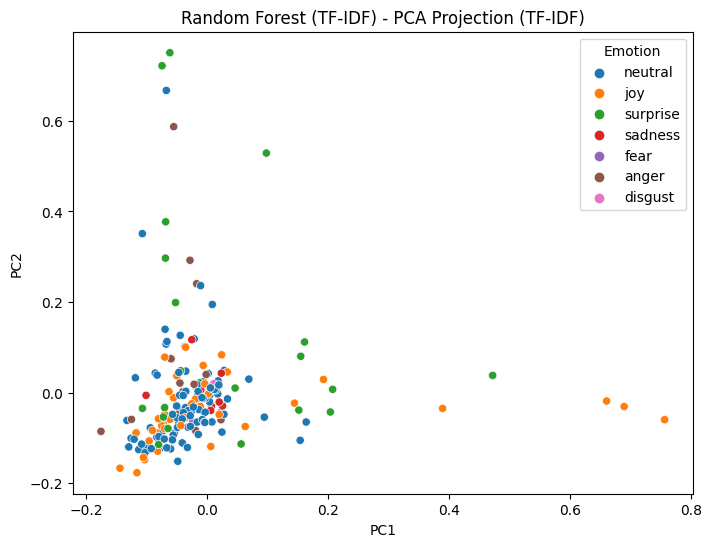

In [26]:
evaluate_tfidf_classifier("Random Forest (TF-IDF)", RandomForestClassifier(n_estimators=100),
                          X_train, X_test, y_train, y_test)

In [27]:
print("Top words in vocabulary:")
print(vectorizer.get_feature_names_out()[:50])

Top words in vocabulary:
['about' 'about me' 'about this' 'about us' 'about what' 'about you'
 'absolutely' 'actually' 'again' 'ah' 'ahh' 'all' 'all night' 'all right'
 'all the' 'almost' 'already' 'also' 'always' 'am' 'amazing' 'an' 'and'
 'and and' 'and he' 'and how' 'and it' 'and just' 'and now' 'and that'
 'and the' 'and then' 'and they' 'and who' 'and you' 'anyone' 'anything'
 'anyway' 'apartment' 'are' 'are you' 'around' 'as' 'ask' 'ask you'
 'asking' 'at' 'at all' 'at the' 'away']


## GloVe Embeddings

To improve upon the limitations of TF-IDF, we used pre-trained GloVe (Global Vectors for Word Representation) embeddings to represent each word in an utterance.

GloVe maps each word to a dense 100-dimensional vector, trained on large corpora like Wikipedia and Common Crawl. These embeddings capture semantic relationships — for example, words like "happy" and "joy" are closer in vector space, while "angry" and "peaceful" are farther apart.

For each utterance, we took the average of the GloVe vectors for all words (after cleaning and tokenizing). This gave us a single dense vector representing the overall meaning of the sentence.

Compared to TF-IDF, GloVe embeddings provide more meaningful representations, especially for short utterances or when words have emotional connotations. However, this approach still doesn't consider word order, and might miss subtle linguistic cues like negation or sarcasm.


In [28]:
glove_path = '/kaggle/input/glove-100d/glove.6B.100d.txt'

glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vec = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vec

print(f"Loaded {len(glove_embeddings)} word vectors.")


Loaded 400000 word vectors.


In [33]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  
    return text.split()

In [34]:
sentence_vectors = []

for utt in tqdm(subset_df['Utterance']):
    tokens = preprocess(utt)
    vecs = [glove_embeddings[word] for word in tokens if word in glove_embeddings]

    if vecs:
        sentence_vec = np.mean(vecs, axis=0)
    else:
        sentence_vec = np.zeros(100)  

    sentence_vectors.append(sentence_vec)

# Create feature matrix
X_glove = np.vstack(sentence_vectors)
y_glove = subset_df['Emotion'].values

print("Sentence embeddings shape:", X_glove.shape)


100%|██████████| 996/996 [00:00<00:00, 24274.68it/s]

Sentence embeddings shape: (996, 100)


In [35]:
def evaluate_glove_classifier(name, model, X_train, X_test, y_train, y_test):
    """
    Evaluate a classifier trained on dense GloVe sentence embeddings.
    Includes: classification report, confusion matrix, PCA projection.
    """
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.decomposition import PCA
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test)

    vis_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    vis_df["Emotion"] = y_pred

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=vis_df, x="PC1", y="PC2", hue="Emotion", palette="tab10")
    plt.title(f"{name} - PCA Projection (GloVe)")
    plt.show()



Logistic Regression (GloVe) Classification Report:
              precision    recall  f1-score   support

       anger       0.25      0.13      0.17        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.21      0.26      0.23        47
     neutral       0.27      0.51      0.36        57
     sadness       0.00      0.00      0.00        19
    surprise       0.13      0.06      0.08        33

    accuracy                           0.23       200
   macro avg       0.12      0.14      0.12       200
weighted avg       0.19      0.23      0.20       200



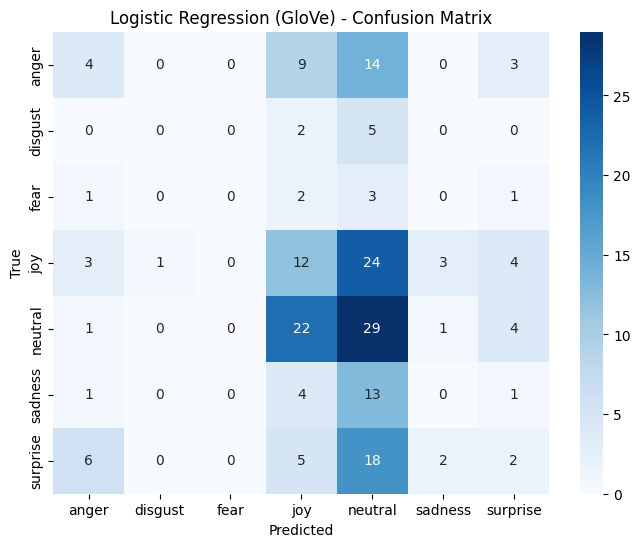

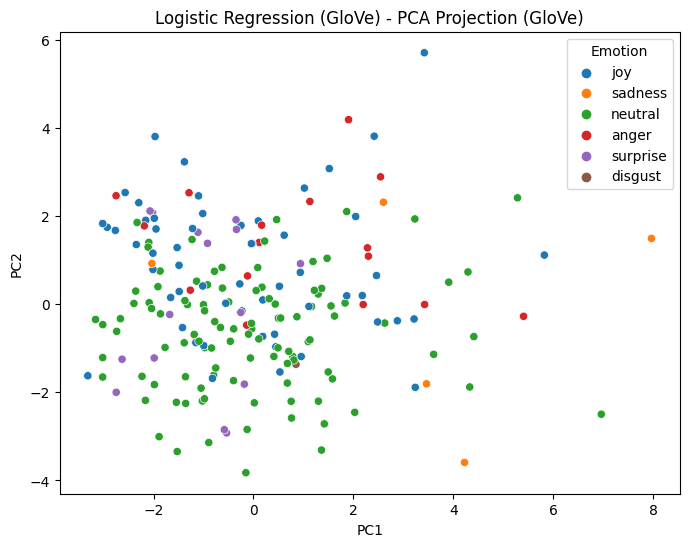

In [36]:
evaluate_glove_classifier("Logistic Regression (GloVe)", LogisticRegression(max_iter=1000),
                          X_train_scaled, X_test_scaled, y_train, y_test)


KNN (GloVe) Classification Report:
              precision    recall  f1-score   support

       anger       0.23      0.33      0.27        30
     disgust       0.00      0.00      0.00         7
        fear       0.33      0.14      0.20         7
         joy       0.22      0.26      0.24        47
     neutral       0.37      0.39      0.38        57
     sadness       0.00      0.00      0.00        19
    surprise       0.26      0.15      0.19        33

    accuracy                           0.25       200
   macro avg       0.20      0.18      0.18       200
weighted avg       0.25      0.25      0.24       200



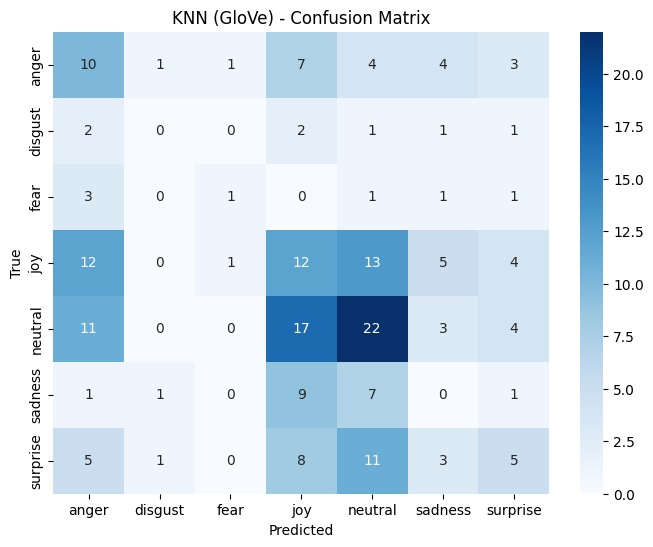

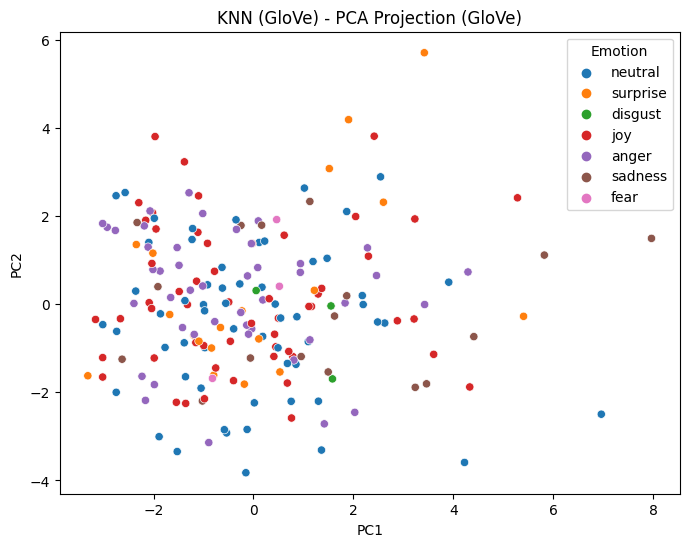

In [37]:
evaluate_glove_classifier("KNN (GloVe)", KNeighborsClassifier(n_neighbors=5),
                          X_train_scaled, X_test_scaled, y_train, y_test)


Random Forest (GloVe) Classification Report:
              precision    recall  f1-score   support

       anger       0.27      0.27      0.27        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.33      0.43      0.37        47
     neutral       0.35      0.56      0.43        57
     sadness       0.00      0.00      0.00        19
    surprise       0.07      0.03      0.04        33

    accuracy                           0.30       200
   macro avg       0.15      0.18      0.16       200
weighted avg       0.23      0.30      0.26       200



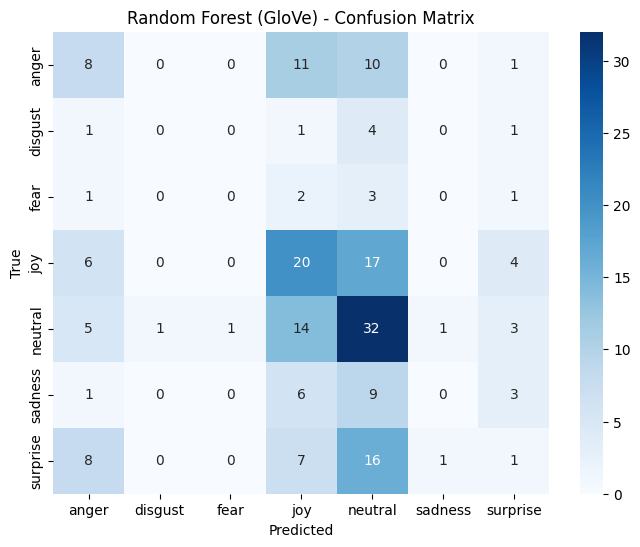

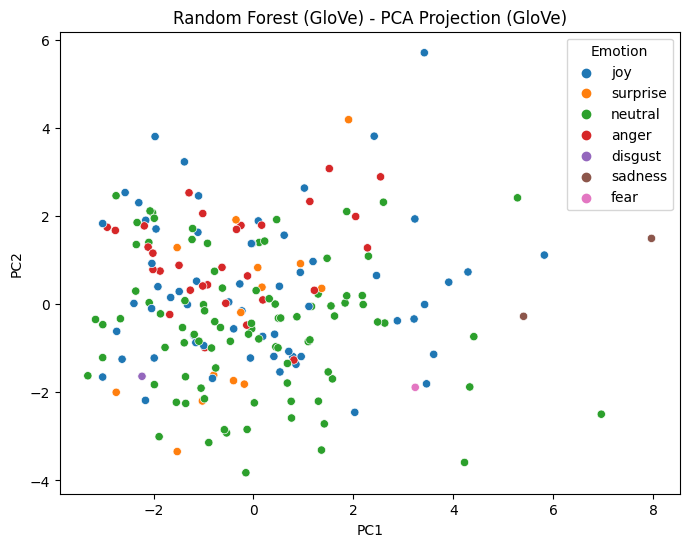

In [38]:

evaluate_glove_classifier("Random Forest (GloVe)", RandomForestClassifier(n_estimators=100),
                          X_train_scaled, X_test_scaled, y_train, y_test)

### **Early Fusion: Combining Audio and Text**

After observing the individual strengths and limitations of audio-only and text-only models, we implemented a simple early fusion strategy to combine both modalities.

For each utterance, we:

- Extracted a **100-dimensional GloVe embedding** to capture the meaning of the spoken sentence  
- Computed a **16-dimensional audio feature vector** consisting of MFCCs, Zero Crossing Rate, Spectral Centroid, and RMS Energy  

We then **concatenated** these vectors to form a single **116-dimensional multimodal feature vector**, which was used as input to classical classifiers like Logistic Regression, KNN, and Random Forest.

This early fusion approach allowed the model to jointly learn from both _what was said_ (text) and _how it was said_ (audio). It improved performance for several emotions, especially where one modality alone was insufficient. However, since the fusion was shallow and based on static features, some confusion remained — particularly between emotions with overlapping tones or semantics.

This approach struck a balance between performance and simplicity, and served as our final model for this project.


In [39]:
X_audio = features_df.drop(columns=['Emotion']).values

y_fused = y_glove  
print("Fused shape:", X_fused.shape)


Fused shape: (996, 116)


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_fused, y_fused, stratify=y_fused, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [41]:
def evaluate_fusion_classifier(name, model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test)
    vis_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    vis_df["Emotion"] = y_pred

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=vis_df, x="PC1", y="PC2", hue="Emotion", palette="tab10")
    plt.title(f"{name} - PCA Projection (Fusion)")
    plt.show()



Logistic Regression (Fusion) Classification Report:
              precision    recall  f1-score   support

       anger       0.39      0.40      0.39        30
     disgust       0.00      0.00      0.00         7
        fear       0.12      0.14      0.13         7
         joy       0.32      0.32      0.32        47
     neutral       0.35      0.37      0.36        57
     sadness       0.10      0.11      0.10        19
    surprise       0.29      0.24      0.26        33

    accuracy                           0.29       200
   macro avg       0.22      0.23      0.22       200
weighted avg       0.29      0.29      0.29       200



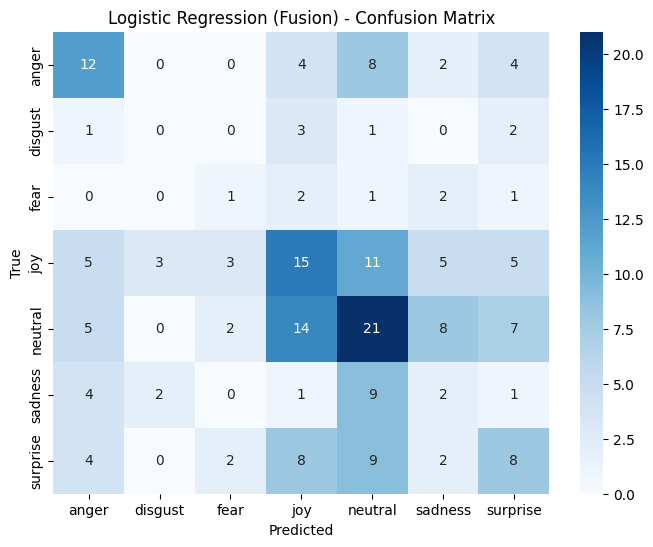

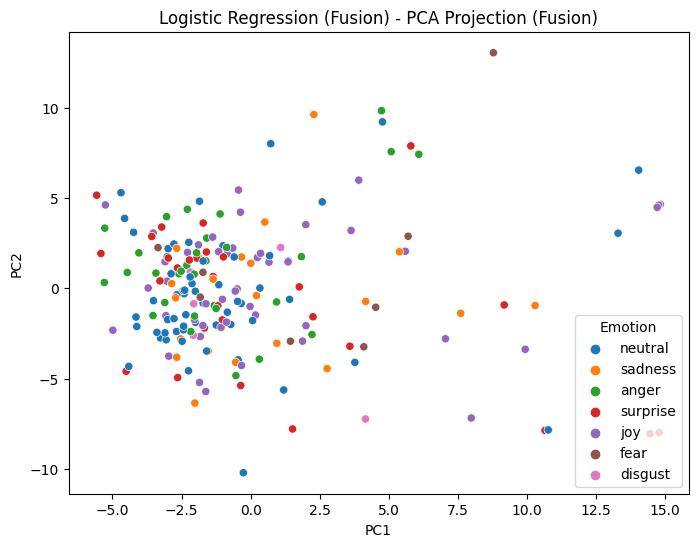

In [44]:
evaluate_fusion_classifier("Logistic Regression (Fusion)", LogisticRegression(max_iter=1000),
                           X_train_scaled, X_test_scaled, y_train, y_test)


KNN (Fusion) Classification Report:
              precision    recall  f1-score   support

       anger       0.25      0.50      0.34        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.25      0.30      0.27        47
     neutral       0.29      0.25      0.26        57
     sadness       0.00      0.00      0.00        19
    surprise       0.46      0.18      0.26        33

    accuracy                           0.24       200
   macro avg       0.18      0.18      0.16       200
weighted avg       0.25      0.24      0.23       200



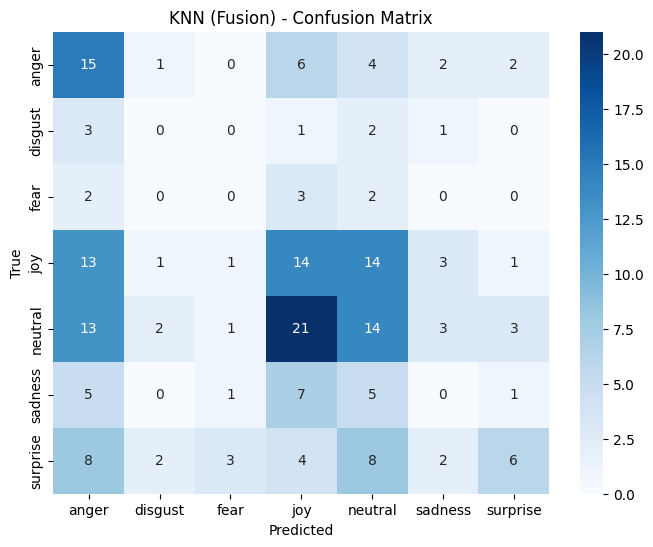

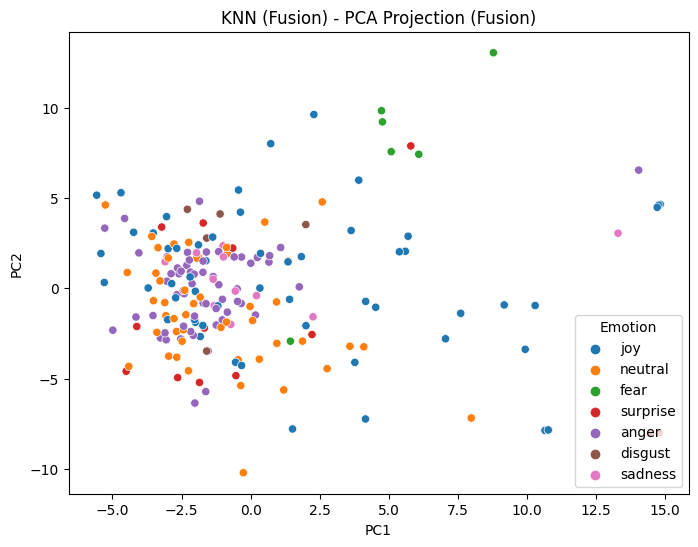

In [45]:
evaluate_fusion_classifier("KNN (Fusion)", KNeighborsClassifier(n_neighbors=5),
                           X_train_scaled, X_test_scaled, y_train, y_test)


Random Forest (Fusion) Classification Report:
              precision    recall  f1-score   support

       anger       0.48      0.33      0.39        30
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         7
         joy       0.28      0.43      0.34        47
     neutral       0.31      0.51      0.38        57
     sadness       0.00      0.00      0.00        19
    surprise       0.70      0.21      0.33        33

    accuracy                           0.33       200
   macro avg       0.25      0.21      0.21       200
weighted avg       0.34      0.33      0.30       200



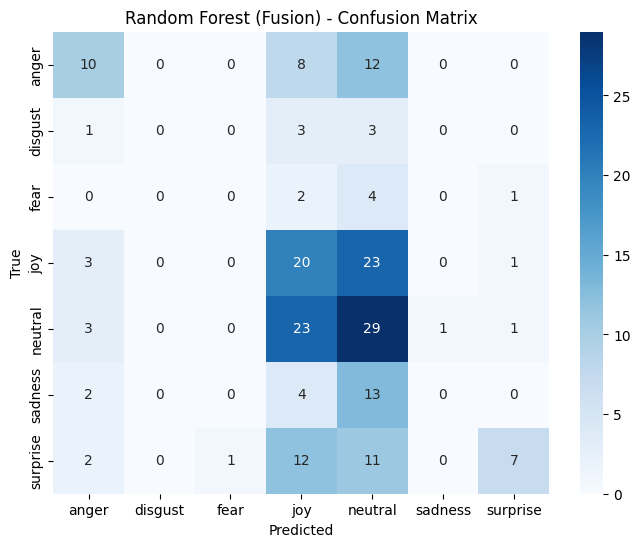

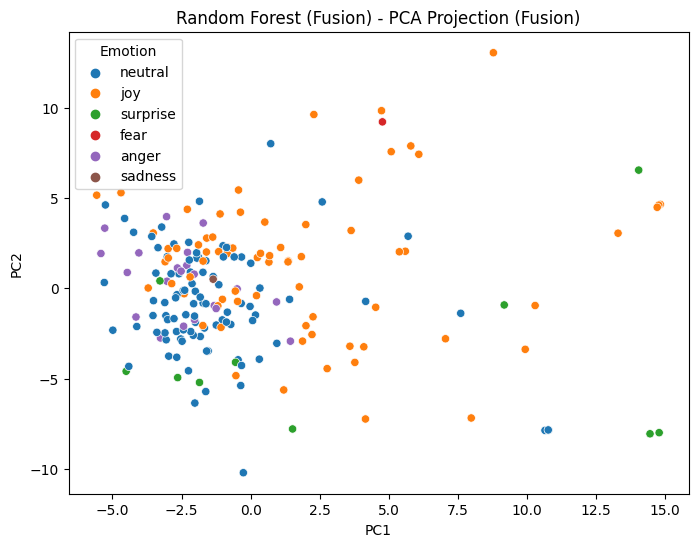

In [46]:
evaluate_fusion_classifier("Random Forest (Fusion)", RandomForestClassifier(n_estimators=100),
                           X_train_scaled, X_test_scaled, y_train, y_test)